In [4]:
%load_ext autoreload
%autoreload 2

device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

import torch 
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from local_attention import LocalAttention
from pianogen.pe import binary_positional_encoding, sinusoidal_positional_encoding

class BinaryPositionalEncoding(nn.Module):
    '''
    Input: B, L (long)
    Output: B, L, D
    '''
    def __init__(self, dim:int, max_len:int):
        super().__init__()
        self.register_buffer('pos_encoding', binary_positional_encoding(max_len, dim).unsqueeze(0))

    def forward(self, pos: torch.Tensor):
        return torch.gather(self.pos_encoding.expand(pos.shape[0], -1, -1), 1, pos.unsqueeze(-1).expand(-1, -1, self.pos_encoding.shape[-1]))
    
class SinusoidalPositionalEncoding(nn.Module):
    '''
    Input: B, L (long)
    Output: B, L, D
    '''
    def __init__(self, dim:int, max_len:int):
        super().__init__()
        self.register_buffer('pos_encoding', sinusoidal_positional_encoding(max_len, dim).unsqueeze(0))

    def forward(self, pos: torch.Tensor):
        return torch.gather(self.pos_encoding.expand(pos.shape[0], -1, -1), 1, pos.unsqueeze(-1).expand(-1, -1, self.pos_encoding.shape[-1]))
    
class LocalMultiHeadAttention(nn.Module):
    '''
    Input: B, L, D
    Output: B, L, D
    '''
    def __init__(self, heads, dim, window_size, causal = False, dropout = 0.):
        super().__init__()
        assert dim % heads == 0, 'dimension must be divisible by number of heads'
        self.heads = heads
        self.to_qkv = nn.Linear(dim, dim * 3, bias = False)
        self.local_attn = LocalAttention(dim = dim // heads, window_size = window_size, causal = causal, dropout = dropout, autopad=True)

    def forward(self, x, mask = None):
        B, L, D = x.shape
        H = self.heads
        E = D // H

        qkv = self.to_qkv(x).chunk(3, dim = -1) # B, L, 3 * H, E
        q, k, v = map(lambda t: t.view(B, L, H, E).transpose(1, 2), qkv)

        out = self.local_attn(q, k, v, mask = mask)
        out = out.transpose(1, 2).reshape(B, L, D)
        return out

class LMHATransformerBlock(nn.Module):
    '''
    Input: B, L, D
    Output: B, L, D
    '''
    def __init__(self, dim, heads, window_size, dim_feedforward, dropout = 0., causal = False):
        super().__init__()
        self.attn = LocalMultiHeadAttention(heads = heads, dim = dim, window_size = window_size, dropout = dropout, causal = causal)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim_feedforward),
            nn.LeakyReLU(),
            nn.Linear(dim_feedforward, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        x = x + self.dropout(self.attn(self.norm1(x), mask = mask))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

class SelectiveAttnTransformer(nn.Module):
    '''
    Token level attention is too expensive to apply on the whole sequence. This module instead learns a regular attention mask with
    a downsampled sequence (segment level), then transform it into the mask for the token level attention, by sparsely select the
    most important segments (the selection is not differentiable though).

    As such, token level attention is only applied on the selected segments, which is much faster.

    Input: B, n_token, n_feature
    '''

    def __init__(self, vocab_size, segment_len, dim = 256):
        super().__init__()

        self.segment_len = segment_len
        self._downsampled_path_enabled = True

        self.binary_pe_dim = 5
        self.sinusoidal_pe_dim = 123
        self.token_embedding = nn.Embedding(vocab_size, dim)
        self.binary_pos_encoding = BinaryPositionalEncoding(self.binary_pe_dim, 10240)
        self.sinusoidal_pos_encoding = SinusoidalPositionalEncoding(self.sinusoidal_pe_dim, 10240)

        self.in_local_attention = nn.Sequential(*[
            LMHATransformerBlock(heads=8, dim=dim, window_size=200, causal=True, dropout=0.1, dim_feedforward=1024) for _ in range(2)
        ])
        self.downsample = nn.AvgPool1d(segment_len, stride=segment_len)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=8, dim_feedforward=1024, batch_first=True), num_layers=4)
        self.upsample = nn.Upsample(scale_factor=segment_len, mode='nearest')
        self.out_local_attention = nn.Sequential(*[
            LMHATransformerBlock(heads=8, dim=dim, window_size=200, causal=True, dropout=0.1, dim_feedforward=1024) for _ in range(2)
        ])
        self.out_linear = nn.Linear(dim, vocab_size)

    def forward(self, x, pos):
        B, L = x.shape
        # x: B, L
        # pos: B, L+1
        x = self.token_embedding(x)

        pe = torch.cat([
            self.binary_pos_encoding(pos),
            self.sinusoidal_pos_encoding(pos),
        ], dim=-1) # B, L+1, D/2

        pe = torch.cat([
            pe[:, :-1], # pe of the input tokens
            pe[:, 1:]   # pe of the target tokens
        ], dim=2) # B, L, D

        x = x + pe
        
        
        x = self.in_local_attention(x)
        before_down = x

        # before entering the downsampled path, we need to make L % segment_len == 0

        if L >= self.segment_len and self._downsampled_path_enabled: # if L < segment_len, we don't need to downsample

            x = x[:, :L - (L % self.segment_len)] # B, L - (L % segment_len), D

            x = self.downsample(x.transpose(1, 2)).transpose(1, 2)
            x = self.transformer(x)
            x = self.upsample(x.transpose(1, 2)).transpose(1, 2) # B, L - (L % segment_len), D

            # to avoid information leak, shift the data from the downsampled path right by segment_len-1
            x = F.pad(x, (0,0,self.segment_len-1, 0), 'constant', 0) # B, L+self.segment_len-1-(L % self.segment_len), D
            # crop redundant right-most stuff due to the right shift
            x = x[:, :L] # B, L, D
            # skip connection
            x = x + before_down

        x = self.out_local_attention(x)
        x = F.leaky_relu(x)
        x = self.out_linear(x)
        return x
    
    def set_downsampled_path_enabled(self, enabled):
        self._downsampled_path_enabled = enabled

class PianoRollGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_linear = nn.Linear(200, 256)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=1024, batch_first=True), num_layers=6)
        self.out_linear = nn.Linear(256, 121)

    def forward(self, x):
        x = self.in_linear(x)
        x = self.transformer(x, mask = nn.Transformer.generate_square_subsequent_mask(x.shape[1]).to(x.device), is_causal = True)
        x = self.out_linear(x)
        return x
        


In [7]:
from pianogen.dataset.pianorolldataset import PianoRollDataset
from pianogen.dataset.tokenized import TokenizedPianoRollDataset
from pianogen.tokenizer import PianoRollTokenizer
from torch.utils.data import DataLoader

# pr_ds = PianoRollDataset('data', max_duration=32*150) # 150 bars
# tokenizer = PianoRollTokenizer(n_pitch=88, n_velocity=32, token_seq_len=10240+1)
# ds = TokenizedPianoRollDataset(pr_ds, tokenizer)
# dl = DataLoader(ds,batch_size=8, shuffle=True, num_workers=8)


pr_ds = PianoRollDataset('data', segment_len=32*4, hop_len=32*4) # 4 bars
tokenizer = PianoRollTokenizer(n_pitch=88, n_velocity=32, token_seq_len=600+1)
ds = TokenizedPianoRollDataset(pr_ds, tokenizer)
dl = DataLoader(ds,batch_size=32, shuffle=True, num_workers=8)

Creating dataset segment_len = 128
Created dataset with 62163 samples from 2570 songs


In [47]:

from tqdm import tqdm
from pianogen.data.pianoroll import Note, PianoRoll

    

tokenizer: PianoRollTokenizer
def inference(file_path:str, length:int=512, prompt:PianoRoll|None=None):
    model.eval()
    if prompt is None:
        tokens = [{'type':'start'}]
    else:
        tokens = ds.tokenizer.tokenize(prompt, pad=False)
        print(tokens)

    last_token = tokens[-1]

    for _ in tqdm(range(length - len(tokens))):
        
        indices = tokenizer.vocab.tokens_to_indices(tokens)
        pos = tokenizer.get_frame_indices(tokens, infer_next_frame=True)
        #output_mask = tokenizer.get_output_mask(tokens[:-1])

        indices = indices.unsqueeze(0).to(device)
        pos = pos.unsqueeze(0).to(device)

        logits = model(indices,pos).squeeze(0)[-1].detach().cpu()
        decoded = tokenizer.sample_from_logits(logits, last_token)
        tokens.append(decoded)
        last_token = decoded

        if decoded['type'] == 'end':
            break

    tokenizer.detokenize(tokens).to_midi(file_path)
    print(tokens)


In [105]:
#inference('output/test.mid', 512,pr_ds.get_piano_roll(53548).slice(0, 32))
from pianogen.data.pianoroll import PianoRoll

inference('output/test.mid', 512,PianoRoll.from_midi(r'W:\Music Generation (old)\samples\free210825_2_C.mid').slice(32*15,32*15+64))

None
[{'type': 'start'}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 12}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 24}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value':

100%|██████████| 388/388 [00:04<00:00, 92.60it/s] 

[{'type': 'start'}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 12}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 24}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'pitch', 'value': 24},

In [8]:
model = SelectiveAttnTransformer(len(tokenizer.vocab),128,256)
crit = nn.CrossEntropyLoss(ignore_index=0)
opt = Adam(model.parameters(), lr=1e-3)
print('number of parameters:', sum(p.numel() for p in model.parameters())/1e6, 'M')

number of parameters: 6.115452 M


In [9]:
model.set_downsampled_path_enabled(False)

In [10]:
# load from checkpoint
start_epoch = 0
if start_epoch > 0:
    checkpoint = torch.load(f'checkpoint/{start_epoch}.pt')
    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])

In [11]:
# train
import time
from tqdm import tqdm

from pianogen import gpu_temp_control

temp_control = gpu_temp_control.GPUTempControl(64,3)


model.to(device)
crit.to(device)

model.train()

for epoch in range(start_epoch,100):
    tq = tqdm(dl)
    for i, batch in enumerate(tq):
        batch = {k:v.to(device) for k,v in batch.items()}
        opt.zero_grad()
        out = model(batch['indices'][:,:-1], batch['pos'])
        loss = crit((out+batch['output_mask']).transpose(1,2), batch['indices'][:,1:])
        loss.backward()
        opt.step()
        temp_control.cooldown()
        if i % 10 == 0:
            # print the loss to tqdm
            tq.set_postfix(batch = i, loss= loss.item(), gpu_temp=temp_control.get_temp())
                    
        if torch.isnan(loss):
            raise ValueError("Loss is NaN")
    
    inference(f'./output/output_{epoch}_{i}.mid', 512)

    if epoch % 10 == 0:
        torch.save({'model':model.state_dict(), 'opt':opt.state_dict()}, f'checkpoint/model_{epoch}.pt')
    



100%|██████████| 1943/1943 [04:28<00:00,  7.23it/s, batch=1940, gpu_temp=62, loss=1.23] 


None


100%|██████████| 512/512 [00:05<00:00, 94.97it/s]


[{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 12, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_fr

100%|██████████| 1943/1943 [04:53<00:00,  6.62it/s, batch=1940, gpu_temp=61, loss=1.16]   


None


100%|██████████| 512/512 [00:05<00:00, 99.26it/s] 


[{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}, {'value': 20, 'type': 'veloc

100%|██████████| 1943/1943 [05:04<00:00,  6.38it/s, batch=1940, gpu_temp=57, loss=1.21]


None


100%|██████████| 512/512 [00:05<00:00, 99.56it/s] 


[{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 23, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 35, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 50, 'type': 

100%|██████████| 1943/1943 [05:08<00:00,  6.30it/s, batch=1940, gpu_temp=61, loss=1.06] 


None


100%|██████████| 512/512 [00:04<00:00, 108.05it/s]


[{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 21, 'type': 'veloc

100%|██████████| 1943/1943 [04:35<00:00,  7.06it/s, batch=1940, gpu_temp=62, loss=1.15] 


None


100%|██████████| 512/512 [00:05<00:00, 95.30it/s]


[{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 12, 'type': 

100%|██████████| 1943/1943 [05:14<00:00,  6.17it/s, batch=1940, gpu_temp=61, loss=1.18] 


None


100%|██████████| 512/512 [00:05<00:00, 95.64it/s]


[{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'

100%|██████████| 1943/1943 [05:16<00:00,  6.14it/s, batch=1940, gpu_temp=61, loss=1.05] 


None


100%|██████████| 512/512 [00:05<00:00, 94.36it/s]


[{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 49, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 15, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type':

100%|██████████| 1943/1943 [05:10<00:00,  6.26it/s, batch=1940, gpu_temp=57, loss=1.08] 


None


100%|██████████| 512/512 [00:05<00:00, 96.18it/s]


[{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 62, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 60, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 16, 'type

100%|██████████| 1943/1943 [04:44<00:00,  6.84it/s, batch=1940, gpu_temp=55, loss=1]    


None


100%|██████████| 512/512 [00:04<00:00, 119.66it/s]


[{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 

100%|██████████| 1943/1943 [04:15<00:00,  7.59it/s, batch=1940, gpu_temp=62, loss=1.02] 


None


100%|██████████| 512/512 [00:04<00:00, 105.83it/s]


[{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 58, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 55, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'ne

100%|██████████| 1943/1943 [05:05<00:00,  6.36it/s, batch=1940, gpu_temp=61, loss=1.22] 


None


100%|██████████| 512/512 [00:05<00:00, 97.24it/s] 


[{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 41, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 44, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'ne

100%|██████████| 1943/1943 [05:14<00:00,  6.18it/s, batch=1940, gpu_temp=57, loss=1.02] 


None


100%|██████████| 512/512 [00:05<00:00, 99.70it/s] 


[{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_fr

100%|██████████| 1943/1943 [05:20<00:00,  6.06it/s, batch=1940, gpu_temp=56, loss=0.994]


None


100%|██████████| 512/512 [00:04<00:00, 104.08it/s]


[{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 38, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}, {'value': 21, 'type': 'veloc

100%|██████████| 1943/1943 [04:14<00:00,  7.62it/s, batch=1940, gpu_temp=55, loss=0.978]


None


100%|██████████| 512/512 [00:04<00:00, 116.76it/s]


[{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame

100%|██████████| 1943/1943 [04:11<00:00,  7.72it/s, batch=1940, gpu_temp=56, loss=1.08] 


None


100%|██████████| 512/512 [00:04<00:00, 117.83it/s]


[{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 32, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 32, 'type': 

100%|██████████| 1943/1943 [04:19<00:00,  7.48it/s, batch=1940, gpu_temp=63, loss=1.04] 


None


100%|██████████| 512/512 [00:04<00:00, 117.90it/s]


[{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 29, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 32, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'},

100%|██████████| 1943/1943 [04:21<00:00,  7.44it/s, batch=1940, gpu_temp=62, loss=1]    


None


100%|██████████| 512/512 [00:05<00:00, 101.26it/s]


[{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}, {'value': 8, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, 

100%|██████████| 1943/1943 [05:16<00:00,  6.14it/s, batch=1940, gpu_temp=57, loss=0.93] 


None


100%|██████████| 512/512 [00:05<00:00, 100.05it/s]


[{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'t

100%|██████████| 1943/1943 [05:20<00:00,  6.06it/s, batch=1940, gpu_temp=55, loss=1.08] 


None


100%|██████████| 512/512 [00:04<00:00, 119.21it/s]


[{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 62, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 63, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}, {'va

100%|██████████| 1943/1943 [04:29<00:00,  7.20it/s, batch=1940, gpu_temp=57, loss=1]    


None


100%|██████████| 512/512 [00:04<00:00, 102.88it/s]


[{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 51, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 55, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 58, 'type': 'pitc

100%|██████████| 1943/1943 [05:21<00:00,  6.04it/s, batch=1940, gpu_temp=57, loss=0.903]


None


100%|██████████| 512/512 [00:05<00:00, 101.22it/s]


[{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 29, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 65, 'type': 

100%|██████████| 1943/1943 [04:54<00:00,  6.60it/s, batch=1940, gpu_temp=55, loss=1]    


None


100%|██████████| 512/512 [00:04<00:00, 115.69it/s]


[{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 46, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 46, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'

  0%|          | 0/1943 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [14]:
ds[0]['indices'][0]

None


tensor(1)

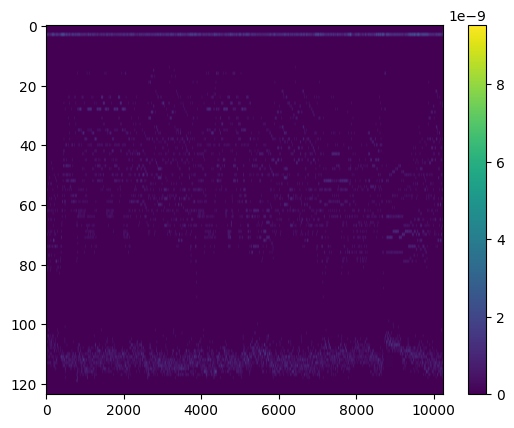

In [36]:
plt.imshow((large_loss_out_grad[0]**2).T, aspect='auto')
plt.colorbar()

In [37]:
large_loss_batch['indices'][0,-250:].cpu().numpy()

array([ 55, 116,  58, 115,  63, 114,  67, 117,   3,   3,  39, 112,  43,
       112,   3,   3,  27, 109,   3,   3,  31, 110,  39, 112,  43, 113,
        58, 114,  70, 115,   3,   3,  29, 114,  57, 115,  60, 114,  65,
       113,  69, 117,   3,   3,  41, 112,  45, 113,   3,   3,  29, 113,
         3,   3,  41, 113,  45, 114,  65, 114,   3,   3,  22, 115,  62,
       116,  65, 115,  70, 114,  74, 118,   3,   3,  34, 113,  38, 112,
         3,   3,  22, 113,   3,   3,  34, 112,  38, 109,   3,   3,  22,
       111,   3,   3,  34, 111,  38, 110,   3,   3,  23, 113,  62, 117,
        74, 117,   3,   3,  35, 110,   3,   3,  24, 114,  36, 114,  60,
       115,  72, 117,   3,   3,  60, 114,  72, 114,   3,  60, 111,  72,
       114,   3,  43, 113,  48, 110,  51, 116,  58, 115,  70, 116,   3,
        51, 111,   3,   3,  72, 112,   3,  39, 111,  43, 114,  48, 113,
        55, 116,  67, 116,   3,  36, 113,   3,  36, 113,   3,   3,  24,
       114,   3,   3,  65, 115,   3,   3,  26, 115,  38, 115,  6

In [ ]:
for i, batch in enumerate(tq):
    break

In [ ]:
device

'cpu'

In [ ]:
import torch
torch.cuda.is_available()

True